# Predicting Future Crime Rates 

## 78705

In [1]:
# importing necessary libraries and configurations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import itertools

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import logging
import warnings

warnings.filterwarnings("ignore")
logging.getLogger("fbprophet").setLevel(logging.ERROR)
plt.style.use("seaborn")
%matplotlib inline

In [2]:
# loading datasets
df = pd.read_csv("df_05.csv")

In [3]:
# data cleaning and indexing

drop = ["zip_code", "latitude", "longitude"]

df.drop(drop, axis=1, inplace=True)
df.occurred_date_time = df.occurred_date_time.astype("datetime64")
df.set_index(["occurred_date_time"], inplace=True)
df.sort_index(inplace=True)

highest_offense_description
BURGLARY OF VEHICLE                                8704
THEFT                                              5662
CRIMINAL MISCHIEF                                  5012
THEFT OF BICYCLE                                   3540
PUBLIC INTOXICATION                                2631
BURGLARY OF RESIDENCE                              2136
WARRANT ARREST NON TRAFFIC                         1551
CRIMINAL TRESPASS                                  1372
AUTO THEFT                                         1370
ASSAULT WITH INJURY                                1274

highest_offense_description
BURGLARY OF VEHICLE                            0.150100
THEFT                                          0.097641
CRIMINAL MISCHIEF                              0.086432
THEFT OF BICYCLE                               0.061047
PUBLIC INTOXICATION                            0.045371
BURGLARY OF RESIDENCE                          0.036835
WARRANT ARREST NON TRAFFIC                     0.026747
CRIMINAL TRESPASS                              0.023660
AUTO THEFT                                     0.023626
ASSAULT WITH INJURY                            0.021970

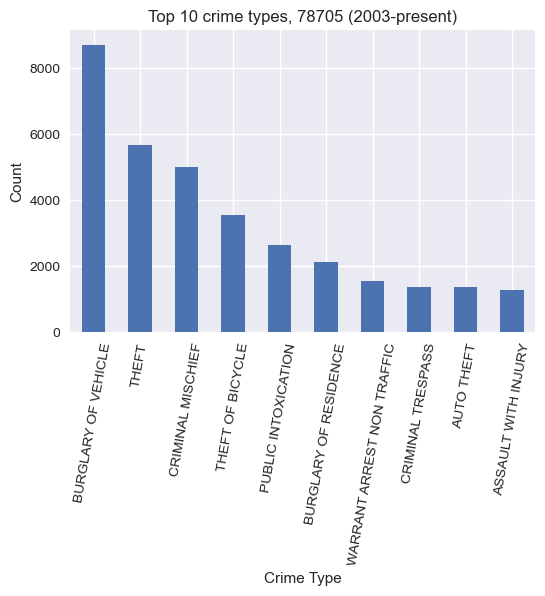

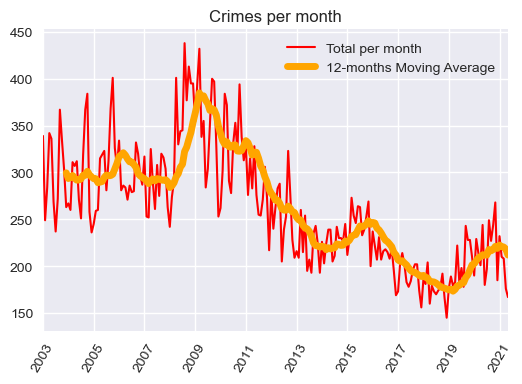

In [4]:
# Create and show dataframe for crime rates by type

display(df.highest_offense_description.value_counts().head(10).to_frame())
display(df.highest_offense_description.value_counts(normalize=True).head(10).to_frame())

# Visualizing the top 10 crime types
plt.figure(dpi=100)
df.highest_offense_description.value_counts().head(10).plot.bar(
    title="Top 10 crime types, 78705 (2003-present)",
    rot=80,
    xlabel="Crime Type",
    ylabel="Count",
)
plt.show()

# Using resample 'M' and rolling window 12
plt.figure(dpi=100)
df.resample("M").size().plot(
    color="red", linewidth=1.5, label="Total per month", rot=60
)
df.resample("M").size().rolling(window=12).mean().plot(
    color="orange", linewidth=5, label="12-months Moving Average", rot=60
)
plt.title("Crimes per month")
plt.xlabel("")
plt.legend()
plt.show()

## ARIMA Modeling with Statsmodels

highest_offense_description
BURGLARY OF VEHICLE                                8704
THEFT                                              5662
CRIMINAL MISCHIEF                                  5012
THEFT OF BICYCLE                                   3540
PUBLIC INTOXICATION                                2631
BURGLARY OF RESIDENCE                              2136
WARRANT ARREST NON TRAFFIC                         1551
CRIMINAL TRESPASS                                  1372
AUTO THEFT                                         1370
ASSAULT WITH INJURY                                1274

BURGLARY OF VEHICLE  PUBLIC INTOXICATION  DWI  \
occurred_date_time                                                  
2021-01-31                           20                  2.0    3   
2021-02-28                           27                  1.0    0   
2021-03-31                           21                  2.0    4   
2021-04-30                           12                  3.0    2   
2021-05-31                           15                  NaN    1   

                    ASSAULT WITH INJURY  CRIMINAL MISCHIEF  CRIMINAL TRESPASS  \
occurred_date_time                                                              
2021-01-31                            3                 14                  9   
2021-02-28                           10                 13                  3   
2021-03-31                            8                 11                  5   
2021-04-30                            5                  7                  9   
2021-05-31                            3                 11                  5   

                    TOTAL  
occurred_date_time         
2021-01-31           51.0  
2021-02-28           54.0  
2021-03-31           51.0  
2021-04-30           38.0  
2021-05-31           35.0

<Figure size 432x288 with 0 Axes>

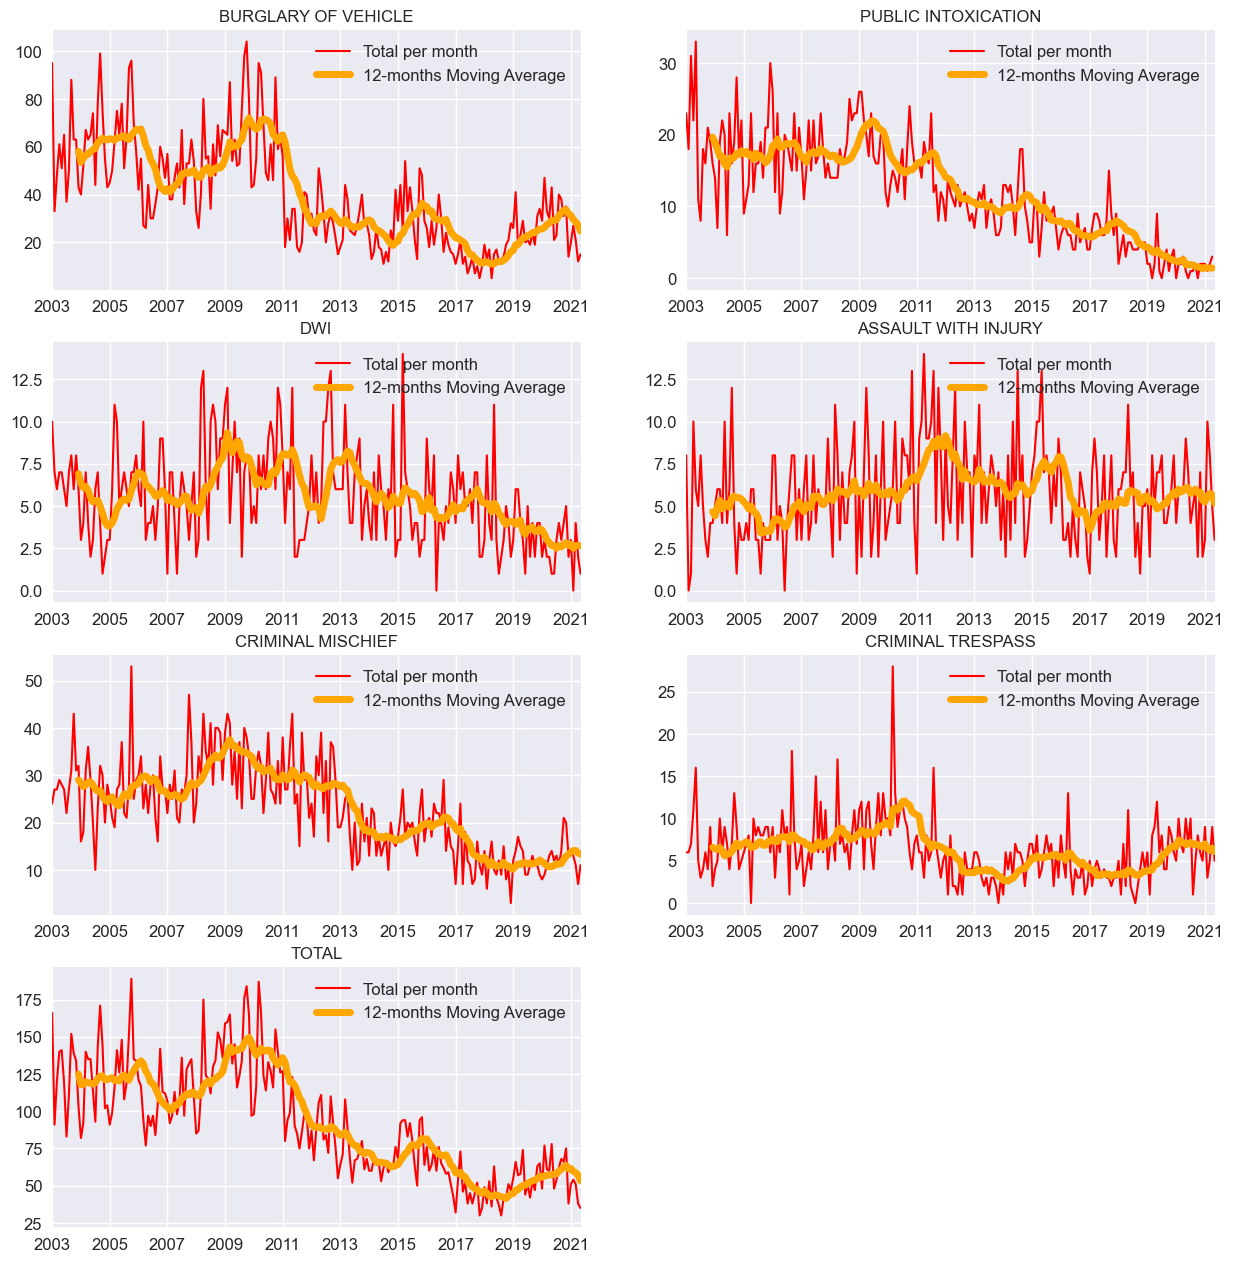

-----------------------------------------------
 Calculating and visualizing the 1st difference
-----------------------------------------------


<Figure size 432x288 with 0 Axes>

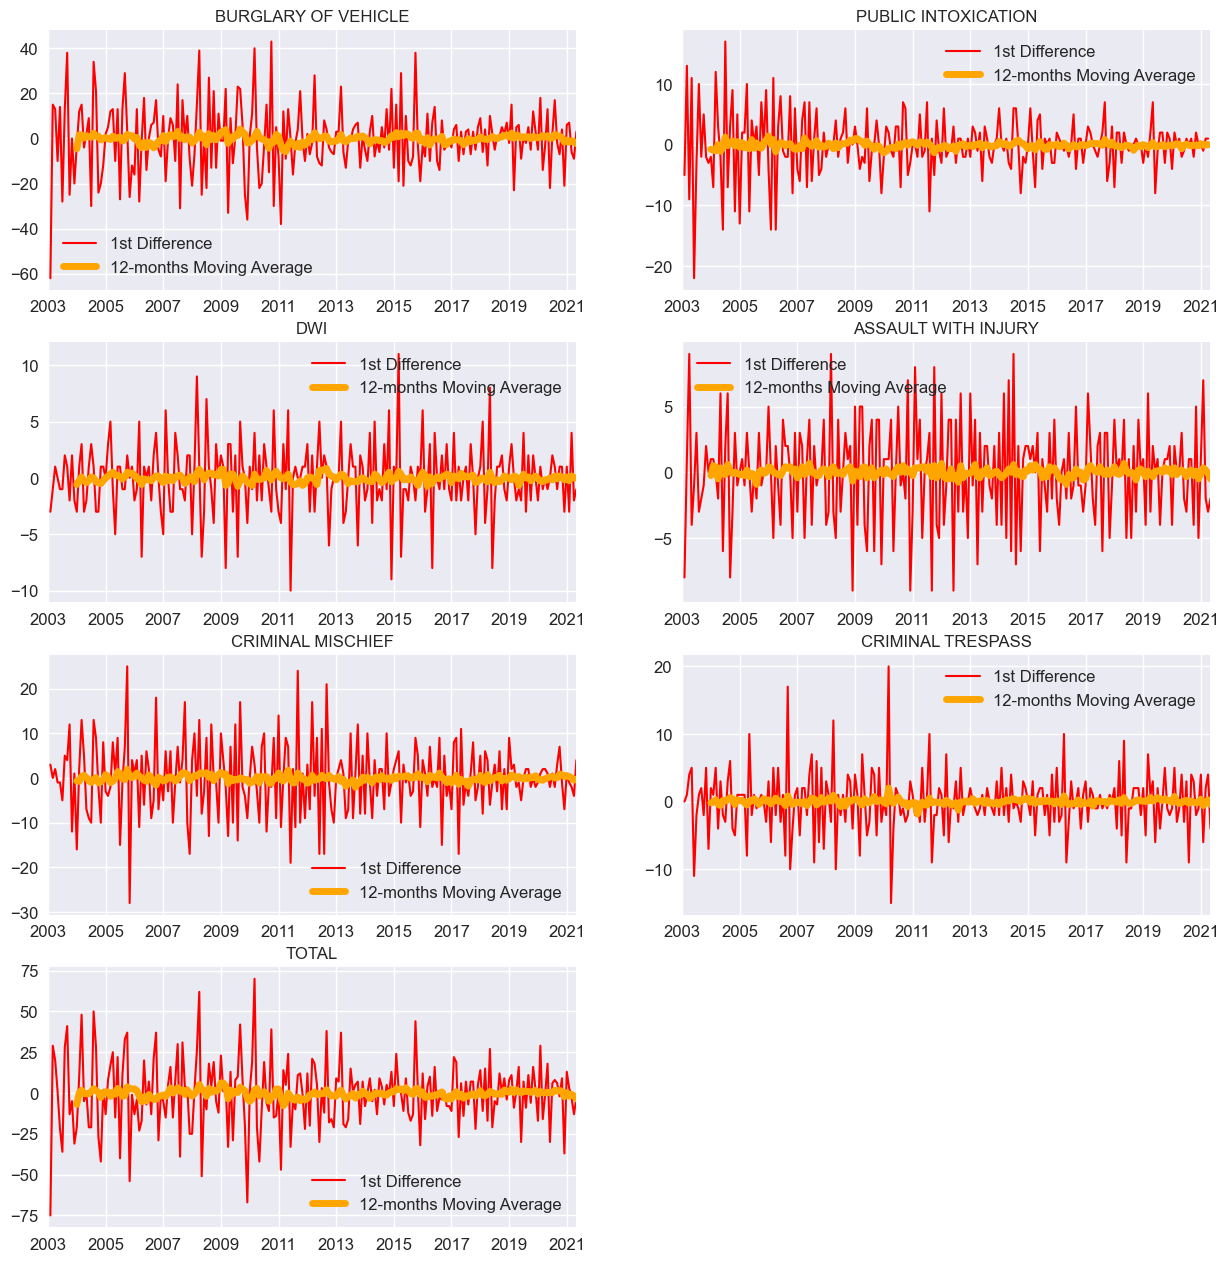

In [5]:
display(df["highest_offense_description"].value_counts().head(10).to_frame())

df2 = df.query(
    'highest_offense_description == ["BURGLARY OF VEHICLE", "PUBLIC INTOXICATION", "CRIMINAL MISCHIEF", "ASSAULT WITH INJURY", "BURGLARY OF VEHICLE", "DWI", "CRIMINAL TRESPASS"]'
)

monthly = pd.DataFrame(
    df2[df2["highest_offense_description"] == "BURGLARY OF VEHICLE"]
    .resample("M")
    .size()
)
monthly.columns = ["BURGLARY OF VEHICLE"]

for i in df2["highest_offense_description"].unique():
    monthly[i] = pd.DataFrame(
        df2[df2["highest_offense_description"] == i].resample("M").size()
    )

monthly["TOTAL"] = monthly.sum(axis=1)

crimeType = monthly.columns

display(monthly.tail())

plt.figure(1)
plt.figure(figsize=(15, 20), dpi=100)

i = 521
for eachCrime in crimeType:
    plt.subplot(i)
    monthly[eachCrime].plot(color="red", linewidth=1.5, label="Total per month")
    monthly[eachCrime].rolling(window=12).mean().plot(
        color="orange", linewidth=5, label="12-months Moving Average"
    )
    plt.title(eachCrime, fontsize=12)
    plt.xlabel("")
    plt.legend(prop={"size": 12})
    plt.tick_params(labelsize=12)
    i = i + 1
plt.show()

print("-----------------------------------------------")
print(" Calculating and visualizing the 1st difference")
print("-----------------------------------------------")
# Initiate the figure and define size
plt.figure(1)
plt.figure(figsize=(15, 20), dpi=100)

# Using a for loop to plot each type of crime with a moving average
i = 521
for eachCrime in crimeType:
    plt.subplot(i)
    monthly[eachCrime].diff().plot(color="red", linewidth=1.5, label="1st Difference")
    monthly[eachCrime].rolling(window=12).mean().diff().plot(
        color="orange", linewidth=5, label="12-months Moving Average"
    )
    plt.title(eachCrime, fontsize=12)
    plt.xlabel("")
    plt.legend(prop={"size": 12})
    plt.tick_params(labelsize=12)
    i = i + 1

In [6]:
# Create a data frame with the 1st difference

montlhy_1stDiff = monthly.diff().dropna()

# Create a data frame with the results of the ADF test for each type

adfullerResults = pd.DataFrame(
    columns=crimeType,
    index=["ADF", "Critical Value 1%", "Critical Value 5%", "p-value"],
)
for eachType in crimeType:
    adf = adfuller(montlhy_1stDiff[eachType])
    adfullerResults[eachType] = (
        "{:.4f}".format(adf[0]),
        "{:.4f}".format(adf[4]["1%"]),
        "{:.4f}".format(adf[4]["5%"]),
        "{:.4f}".format(adf[1]),
    )
adfullerResults

BURGLARY OF VEHICLE PUBLIC INTOXICATION      DWI  \
ADF                          -11.1769             -7.2451  -9.2996   
Critical Value 1%             -3.4613             -3.4622  -3.4616   
Critical Value 5%             -2.8751             -2.8755  -2.8753   
p-value                        0.0000              0.0000   0.0000   

                  ASSAULT WITH INJURY CRIMINAL MISCHIEF CRIMINAL TRESPASS  \
ADF                           -7.7994           -6.4233           -7.8080   
Critical Value 1%             -3.4622           -3.4622           -3.4619   
Critical Value 5%             -2.8755           -2.8755           -2.8754   
p-value                        0.0000            0.0000            0.0000   

                     TOTAL  
ADF                -6.8937  
Critical Value 1%  -3.4622  
Critical Value 5%  -2.8755  
p-value             0.0000

'BURGLARY OF VEHICLE'

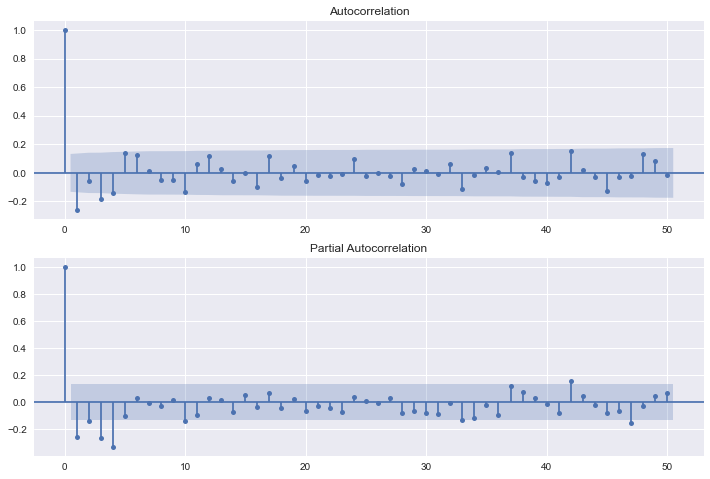

In [7]:
display(montlhy_1stDiff[crimeType[0]].name)
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(montlhy_1stDiff[crimeType[0]], lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(montlhy_1stDiff[crimeType[0]], lags=50, ax=ax2)

In [8]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print("Examples of parameter combinations for Seasonal ARIMA...")
print("SARIMAX: {} x {}".format(pdq[1], seasonal_pdq[1]))
print("SARIMAX: {} x {}".format(pdq[1], seasonal_pdq[2]))
print("SARIMAX: {} x {}".format(pdq[2], seasonal_pdq[3]))
print("SARIMAX: {} x {}".format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [9]:
# Creating a function to use a pipeline
def myArima(crimeTypeSeries):
    print("Training for:", crimeTypeSeries.name)
    lowestAIC = 999999999
    bestOrder = 0
    bestSeasonal_order = 0
    i = 0
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(
                    crimeTypeSeries, order=param, seasonal_order=param_seasonal
                )
                results = mod.fit()
                newAIC = results.aic
                if newAIC < lowestAIC:
                    lowestAIC = newAIC
                    bestOrder = param
                    bestSeasonal_order = param_seasonal
                i = i + 1
                print("\r", "Calculating: {:.0f}%".format(i / 64 * 100), end="")
            except:
                i = i + 1
                print("\r", "Calculating: {:.0f}%".format(i / 64 * 100), end="")
                continue
    print("\nBest parameters: SARIMA{}x{}12".format(param, param_seasonal))
    mod = sm.tsa.statespace.SARIMAX(
        crimeTypeSeries, order=bestOrder, seasonal_order=bestSeasonal_order
    )
    results = mod.fit()
    results.plot_diagnostics(figsize=(15, 12))
    plt.show()
    pred = results.get_prediction(start=168, end=230, dynamic=False)
    pred_ci = pred.conf_int()
    pred_ci.head()
    plt.figure(figsize=(15, 6))
    ax = crimeTypeSeries.plot(label="observed")
    plt.title("Actual and Forecast", fontsize=12)
    pred.predicted_mean.plot(
        ax=ax, label="One-step ahead forecast", color="red", alpha=0.7, lw=4
    )
    ax.fill_between(
        pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color="r", alpha=0.3
    )
    ax.set_xlabel("Years")
    ax.set_ylabel("Number of crime")
    plt.legend()
    plt.show()
    return results

Training for: BURGLARY OF VEHICLE
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


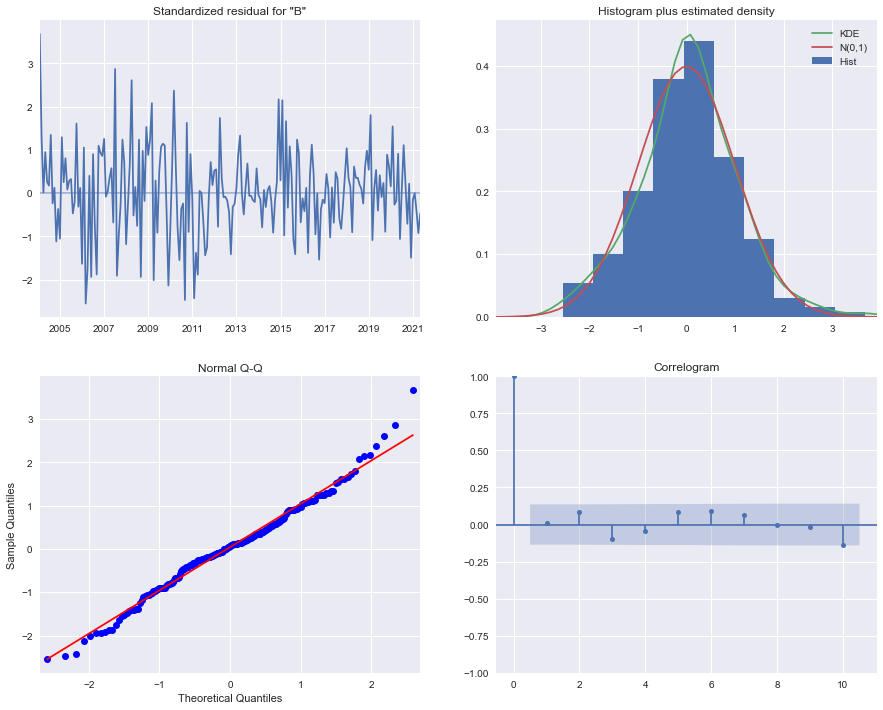

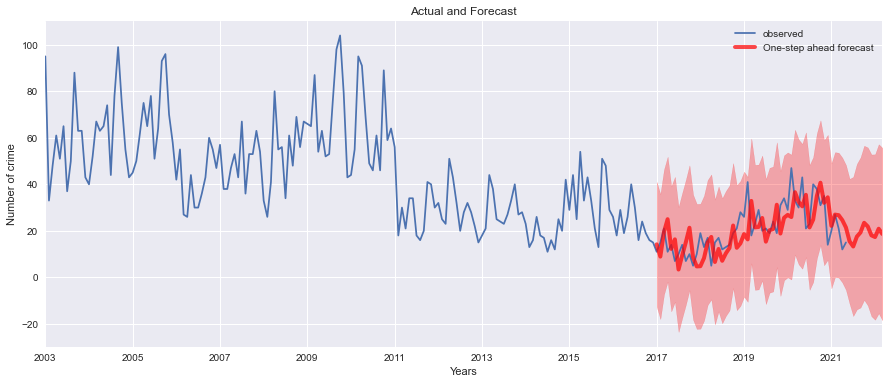

Training for: PUBLIC INTOXICATION
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


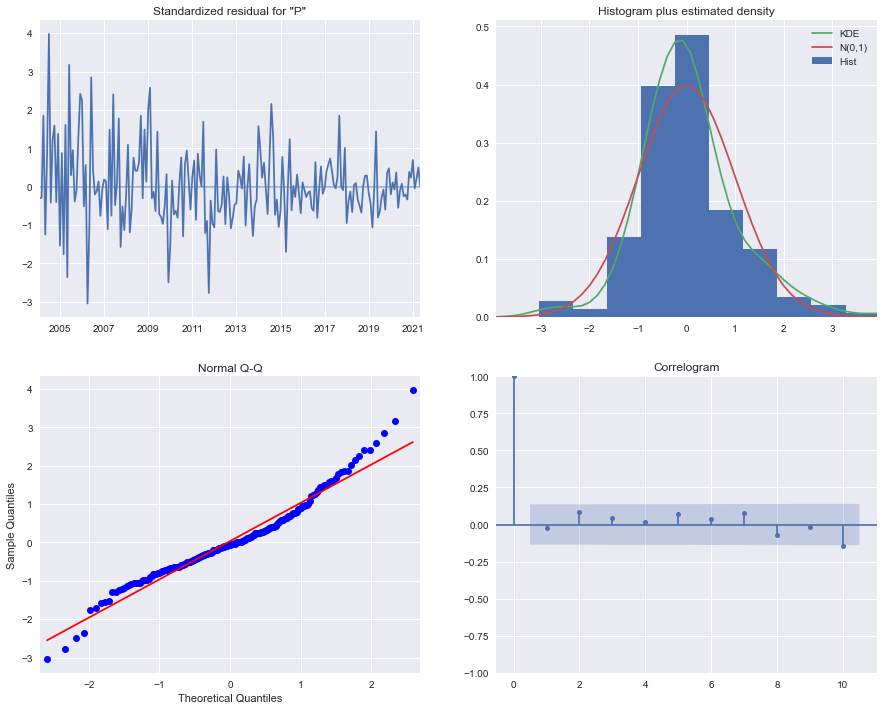

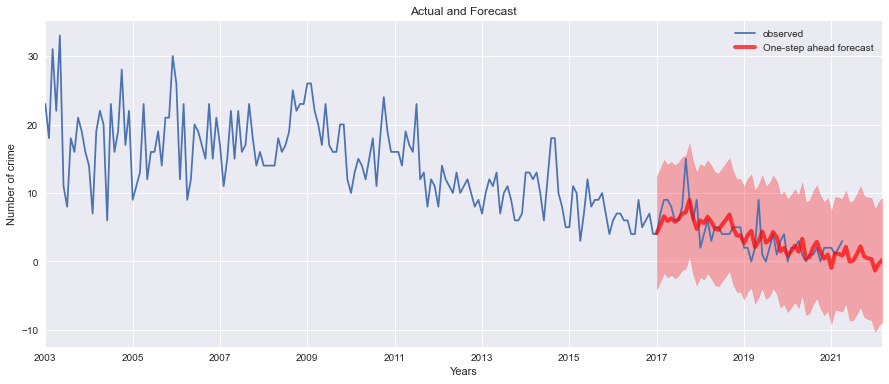

Training for: DWI
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


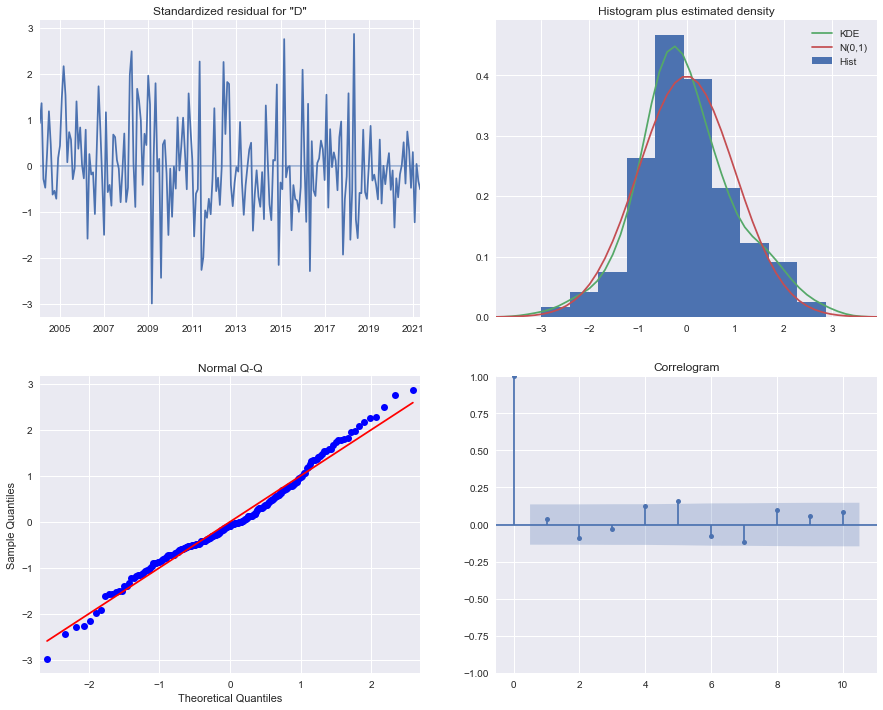

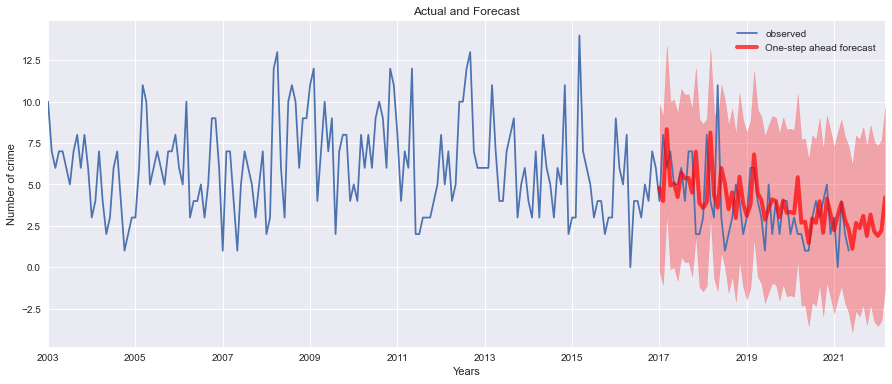

Training for: ASSAULT WITH INJURY
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


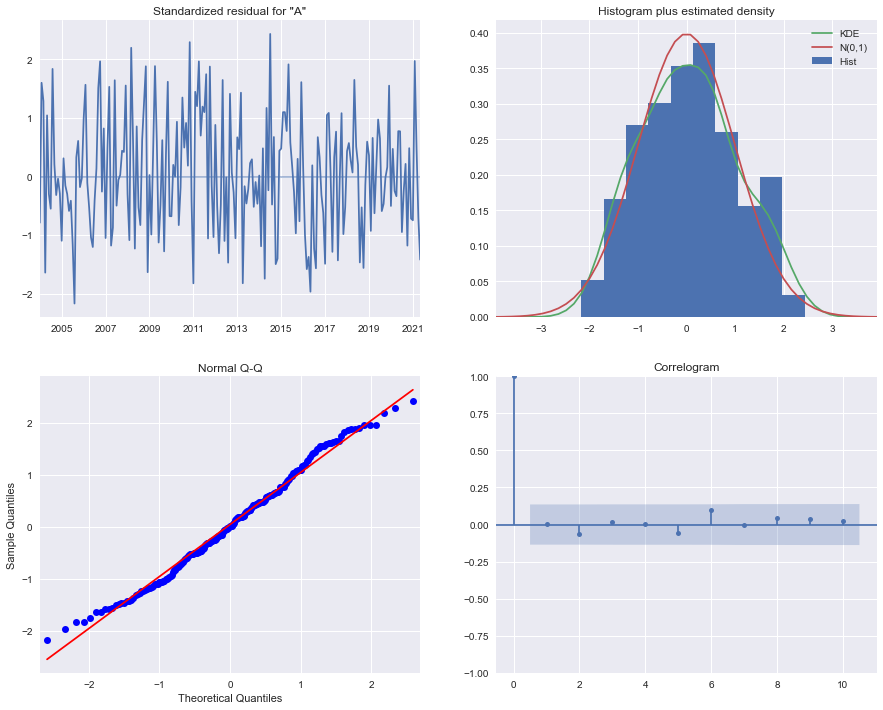

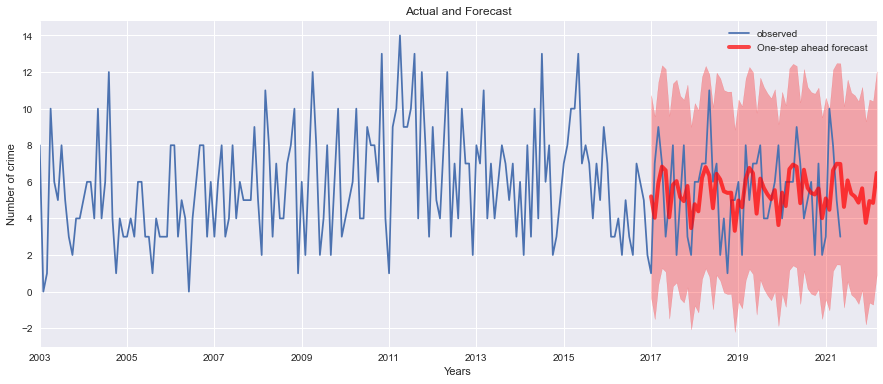

Training for: CRIMINAL MISCHIEF
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


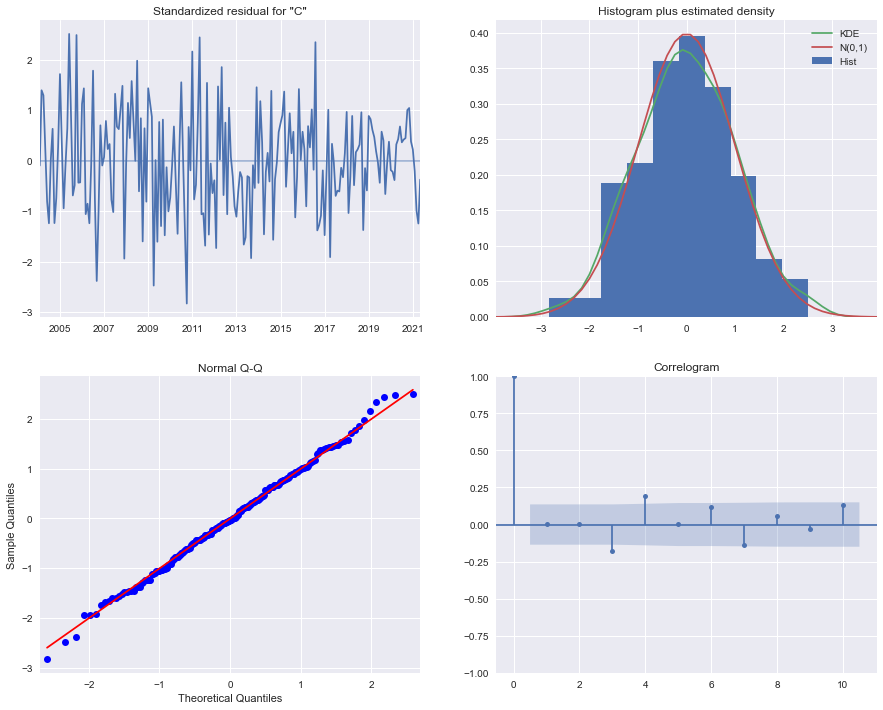

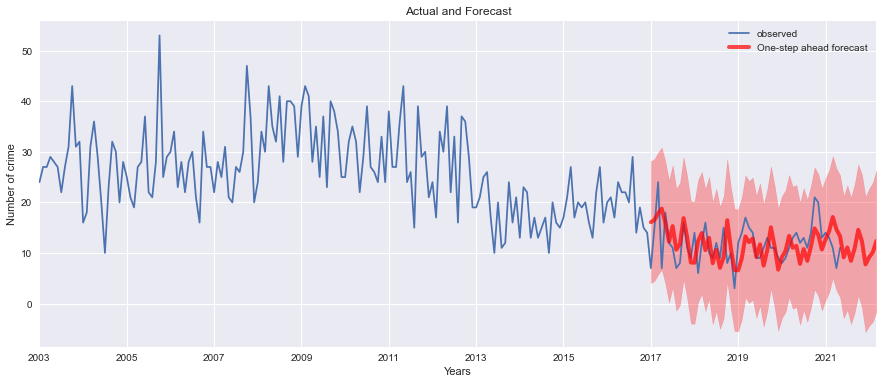

Training for: CRIMINAL TRESPASS
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


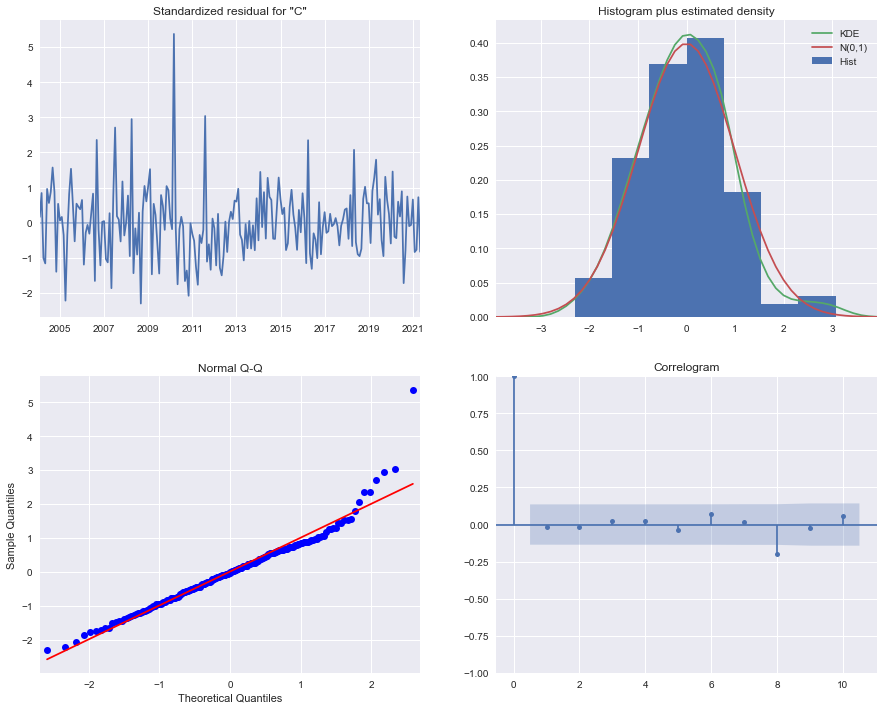

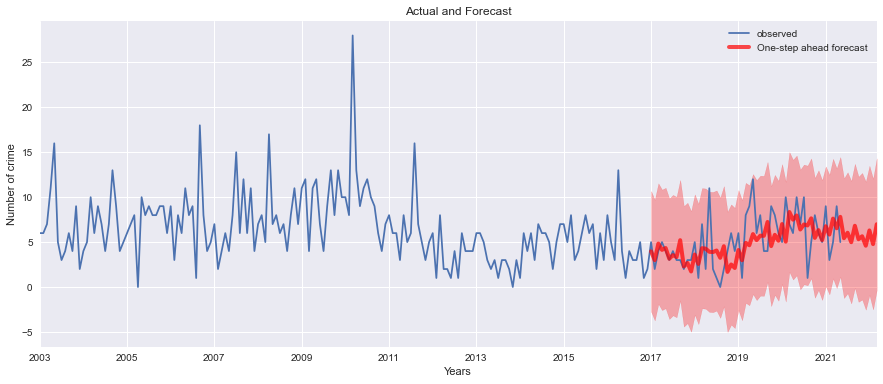

Training for: TOTAL
 Calculating: 100%
Best parameters: SARIMA(1, 1, 1)x(1, 1, 1, 12)12


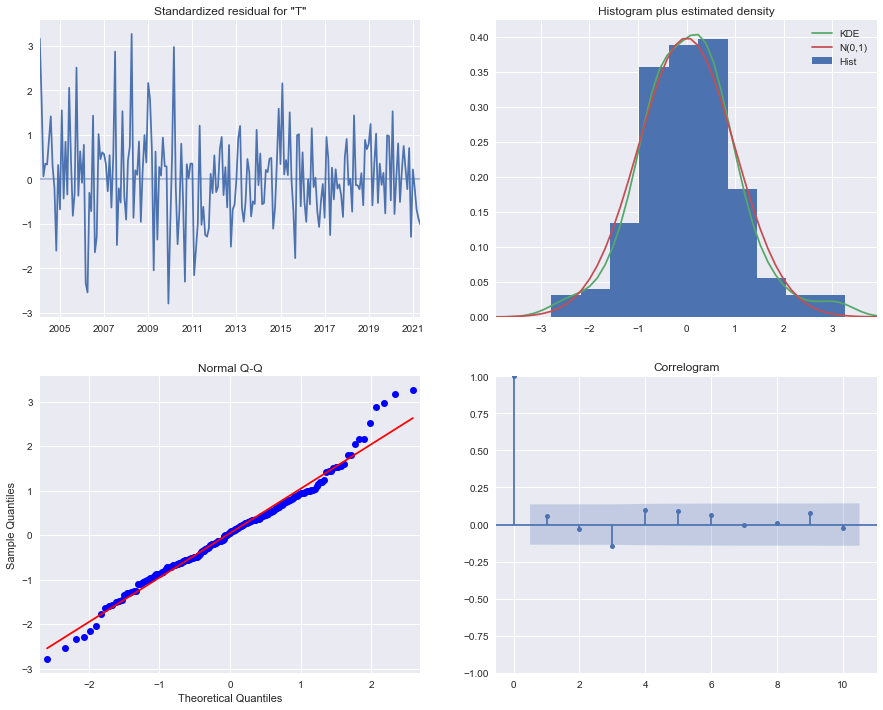

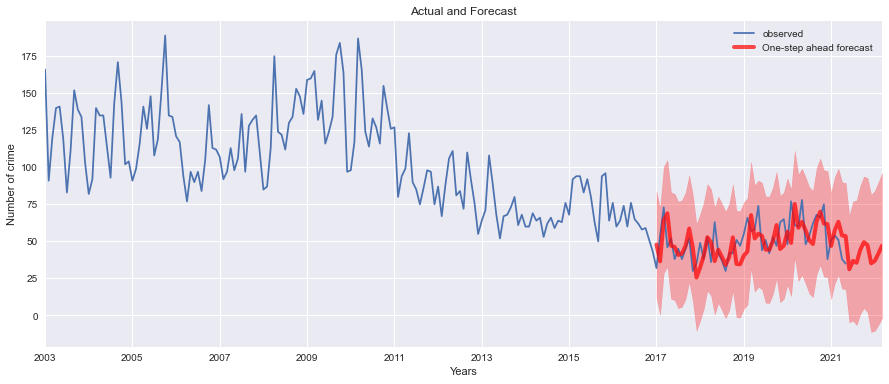

In [10]:
results = []
for i in crimeType:
    results.append(myArima(monthly[i]))

In [11]:
predictions = []
for i in range(0, len(results)):
    predictions.append(
        results[i].get_prediction(start=204, end=230, dynamic=False).predicted_mean
    )

In [12]:
# Calculating MAPE error
predictions = pd.DataFrame(predictions)
predictions = predictions.transpose()
predictions.columns = monthly.columns
errors = (monthly - predictions) / monthly
errors.dropna(how="all", inplace=True)
n = len(errors)

MAPE = round((errors.abs().sum() / n) * 100, 2)
print(
    "The Mean Absolute Percentage Error for each type for the year 01/2020 to 12/2021"
)
display(MAPE)

The Mean Absolute Percentage Error for each type for the year 01/2020 to 12/2021


BURGLARY OF VEHICLE    34.93
PUBLIC INTOXICATION      inf
DWI                      inf
ASSAULT WITH INJURY    48.81
CRIMINAL MISCHIEF      27.31
CRIMINAL TRESPASS      66.36
TOTAL                  21.86
dtype: float64

In [13]:
# Formulating the confidence interval
predictions_ci = []
for i in range(0, len(results)):
    predictions_ci.append(
        results[i].get_prediction(start=204, end=230, dynamic=False).conf_int()
    )

# display(predictions_ci)

# Building a forecast table
def forecastMonth(year_month):
    for i in range(0, 9):
        pred_df = round(predictions.iloc[:, i : i + 1][year_month], 0)
        ci_df = round(predictions_ci[i][year_month], 0)
        ci_df.columns = ["Lower CI", "Upper CI"]
        frames = (pred_df, ci_df)
        display(pd.concat(frames, axis=1))


forecastMonth("2021-05")

BURGLARY OF VEHICLE  Lower CI  Upper CI
2021-05-31                 21.0      -5.0      48.0

PUBLIC INTOXICATION  Lower CI  Upper CI
2021-05-31                  2.0      -6.0      10.0

DWI  Lower CI  Upper CI
2021-05-31  2.0      -3.0       7.0

ASSAULT WITH INJURY  Lower CI  Upper CI
2021-05-31                  7.0       1.0      12.0

CRIMINAL MISCHIEF  Lower CI  Upper CI
2021-05-31               13.0       1.0      25.0

CRIMINAL TRESPASS  Lower CI  Upper CI
2021-05-31                8.0       1.0      14.0

TOTAL  Lower CI  Upper CI
2021-05-31   54.0      18.0      89.0

IndexError: list index out of range

## Predicting crime rates with Facebook Prophet 

### Modeling the data as-is

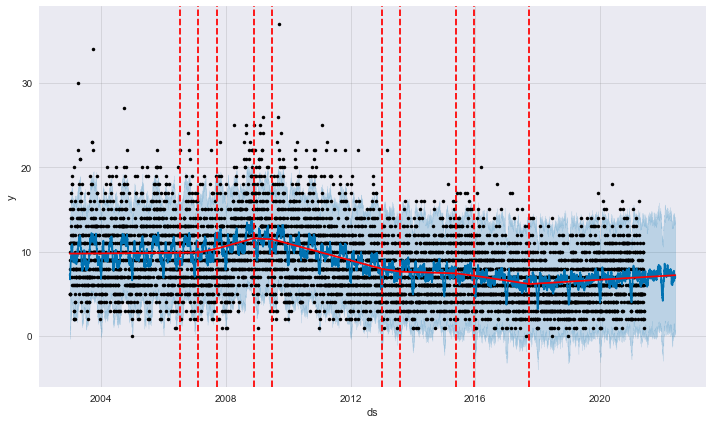

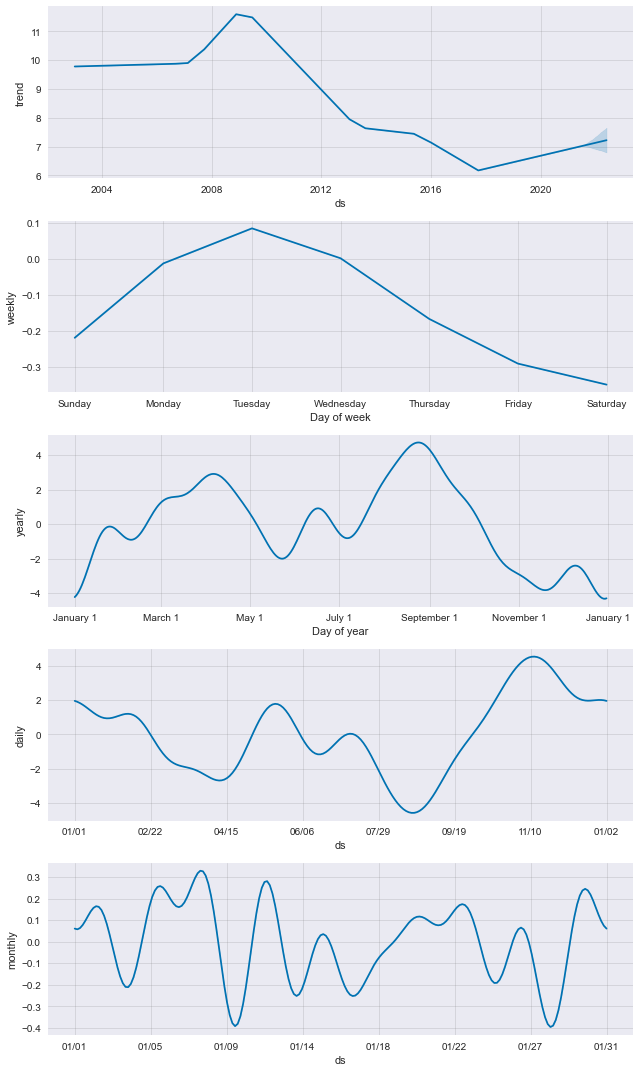

In [20]:
# Prepping to forecast
df_fbprophet = df.copy()
df_m = df_fbprophet.resample("D").size().reset_index()
df_m.columns = ["date", "daily_crime_count"]
df_m_final = df_m.rename(columns={"date": "ds", "daily_crime_count": "y"})
# df_m_final["y"] = np.log(df_m_final["y"])
df_m_final["y"] = pd.to_numeric(df_m_final["y"])
y = df_m_final["y"].to_frame()
y.index = df_m_final["ds"]
n = np.int(y.count())

# Fitting and configuring the model
m = Prophet(interval_width=0.95)
m.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m.add_seasonality(name="weekly", period=52, fourier_order=10)
m.add_seasonality(name="daily", period=366, fourier_order=10)
m.fit(df_m_final)

future = m.make_future_dataframe(periods=366, freq="D")

forecast = m.predict(future)

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

fig2 = m.plot_components(forecast)

fig2_1 = plot_plotly(m, forecast)
fig2_1

In [21]:
# The forecast is 'log transformed', so we need to 'inverse' it back by using the exp
forecast_df_exp = np.exp(forecast[["yhat", "yhat_lower", "yhat_upper"]])
forecast_df_exp.index = forecast["ds"]

# Calculating MAPE error
error = forecast_df_exp["yhat"] - y["y"]
MAPE_df = (error / y["y"]).abs().sum() / n * 100
round(MAPE_df, 2)

inf

### Mitigating outlier effects on moodel accuracy 

In [22]:
# Make another copy of the data frame as m2
df_prophet2 = df_m_final.copy()

# Define the Upper Control Limit and Lower Control Limit as 3 standard deviations from the mean
ucl = df_prophet2.mean() + df_prophet2.std() * 3
lcl = df_prophet2.mean() - df_prophet2.std() * 3

# display the number of outliers found
print(
    "Above 3 standard deviations: ",
    df_prophet2[df_prophet2["y"] > ucl["y"]]["y"].count(),
    "entries",
)
print(
    "Below 3 standard deviations: ",
    df_prophet2[df_prophet2["y"] < lcl["y"]]["y"].count(),
    "entries",
)

Above 3 standard deviations:  60 entries
Below 3 standard deviations:  0 entries


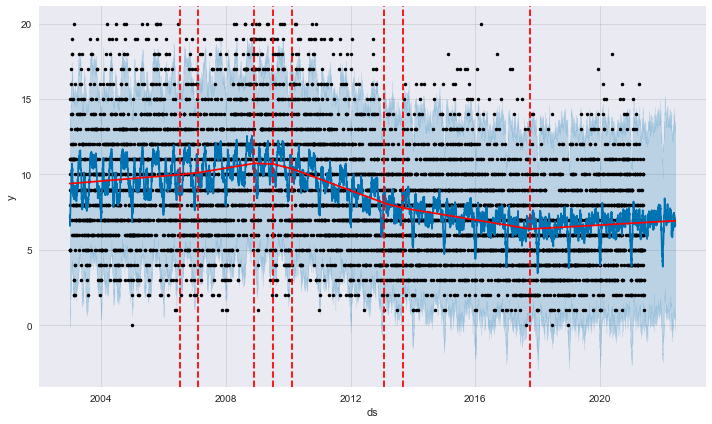

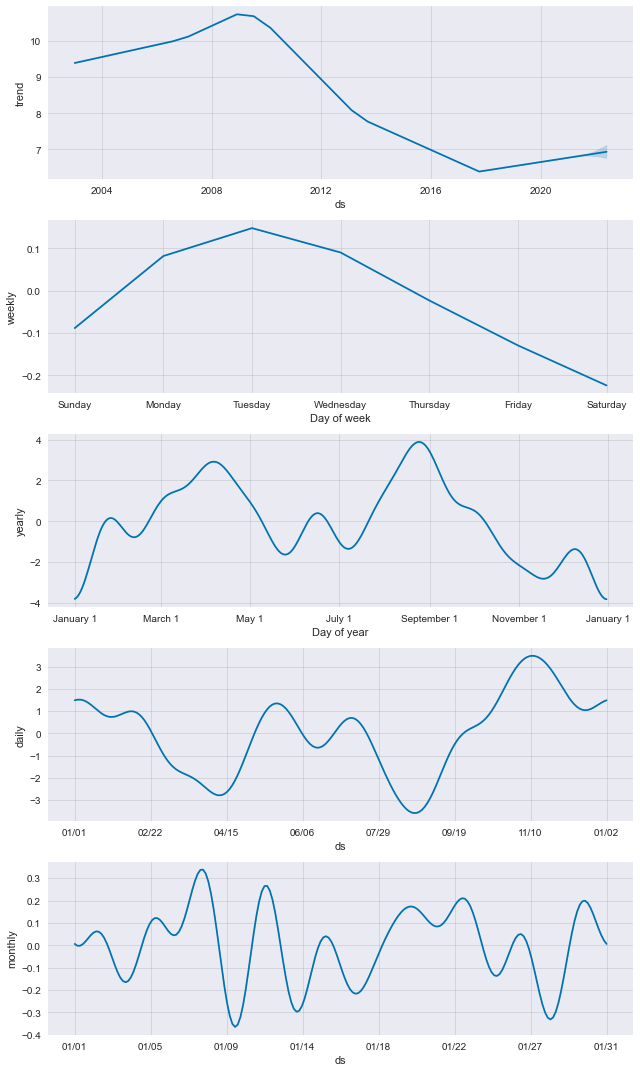

In [23]:
# Remove them by setting their value to None. Prophet says it can handle null values.
df_prophet2.loc[df_prophet2["y"] > ucl["y"], "y"] = None
df_prophet2.loc[df_prophet2["y"] < lcl["y"], "y"] = None

# Log transformation
# df_prophet2["y"] = np.log(df_prophet2["y"])
df_prophet2["y"] = pd.to_numeric(df_prophet2["y"])

# Run Prophet using model 2
m2 = Prophet(interval_width=0.95)
m2.add_seasonality(name="monthly", period=30.5, fourier_order=10)
m2.add_seasonality(name="weekly", period=52, fourier_order=10)
m2.add_seasonality(name="daily", period=366, fourier_order=10)
m2.fit(df_prophet2)

future = m2.make_future_dataframe(periods=366)

forecast_m2 = m2.predict(future)

fig_m2 = m2.plot(forecast_m2)
a = add_changepoints_to_plot(fig_m2.gca(), m2, forecast_m2)

fig2m2 = m2.plot_components(forecast_m2)

fig2_1m2 = plot_plotly(m2, forecast_m2)
fig2_1m2

In [24]:
# Re-inversing the forecast
forecast_m2_exp = np.exp(forecast_m2[["yhat", "yhat_lower", "yhat_upper"]])
forecast_m2_exp.index = forecast_m2["ds"]

# RecalculatinG MAPE error
error = forecast_m2_exp["yhat"] - y["y"]
MAPE_m2 = (error / y["y"]).abs().sum() / n * 100
round(MAPE_m2, 2)

inf

  0%|          | 0/4 [00:00<?, ?it/s]

horizon       mse      rmse       mae     mdape  coverage
0 37 days  9.030157  3.005022  2.406690  0.358555  0.965753
1 38 days  9.291489  3.048194  2.451252  0.360078  0.965753
2 39 days  9.152581  3.025323  2.418999  0.349557  0.965753
3 40 days  8.905682  2.984239  2.385715  0.346740  0.969178
4 41 days  8.762176  2.960097  2.374401  0.353984  0.972603

horizon       mse      rmse       mae     mdape  coverage
324 361 days  8.889059  2.981452  2.226760  0.283829  0.965753
325 362 days  9.070339  3.011700  2.263673  0.283829  0.965753
326 363 days  9.316642  3.052317  2.316378  0.299171  0.965753
327 364 days  9.751667  3.122766  2.369708  0.304170  0.958904
328 365 days  9.903812  3.147032  2.405861  0.304170  0.958904

TypeError: 'NoneType' object is not subscriptable

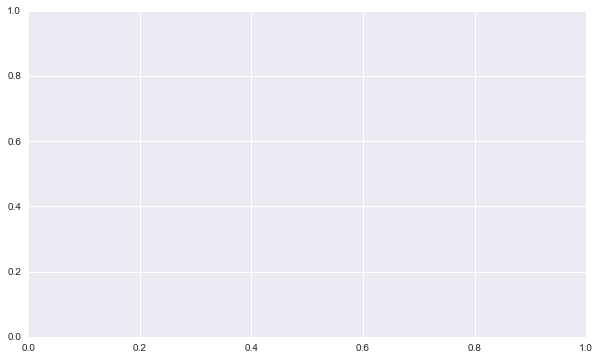

In [25]:
# Doing a diagnostic and performance metrics check visualizing the results

b = cross_validation(m2, initial="5110 days", period="365 days", horizon="365 days")

p = performance_metrics(b)
display(p.head())
display(p.tail())

fig4 = plot_cross_validation_metric(b, metric="mape")